Analyizing Topology: random_20N
  > Processing config: ideal
  > Processing config: lossy
  > Processing config: stable
  > Processing config: stable_high_pl
  > Processing config: stable_mid_pl
  > Processing config: unstable

Plots generated. Showing...


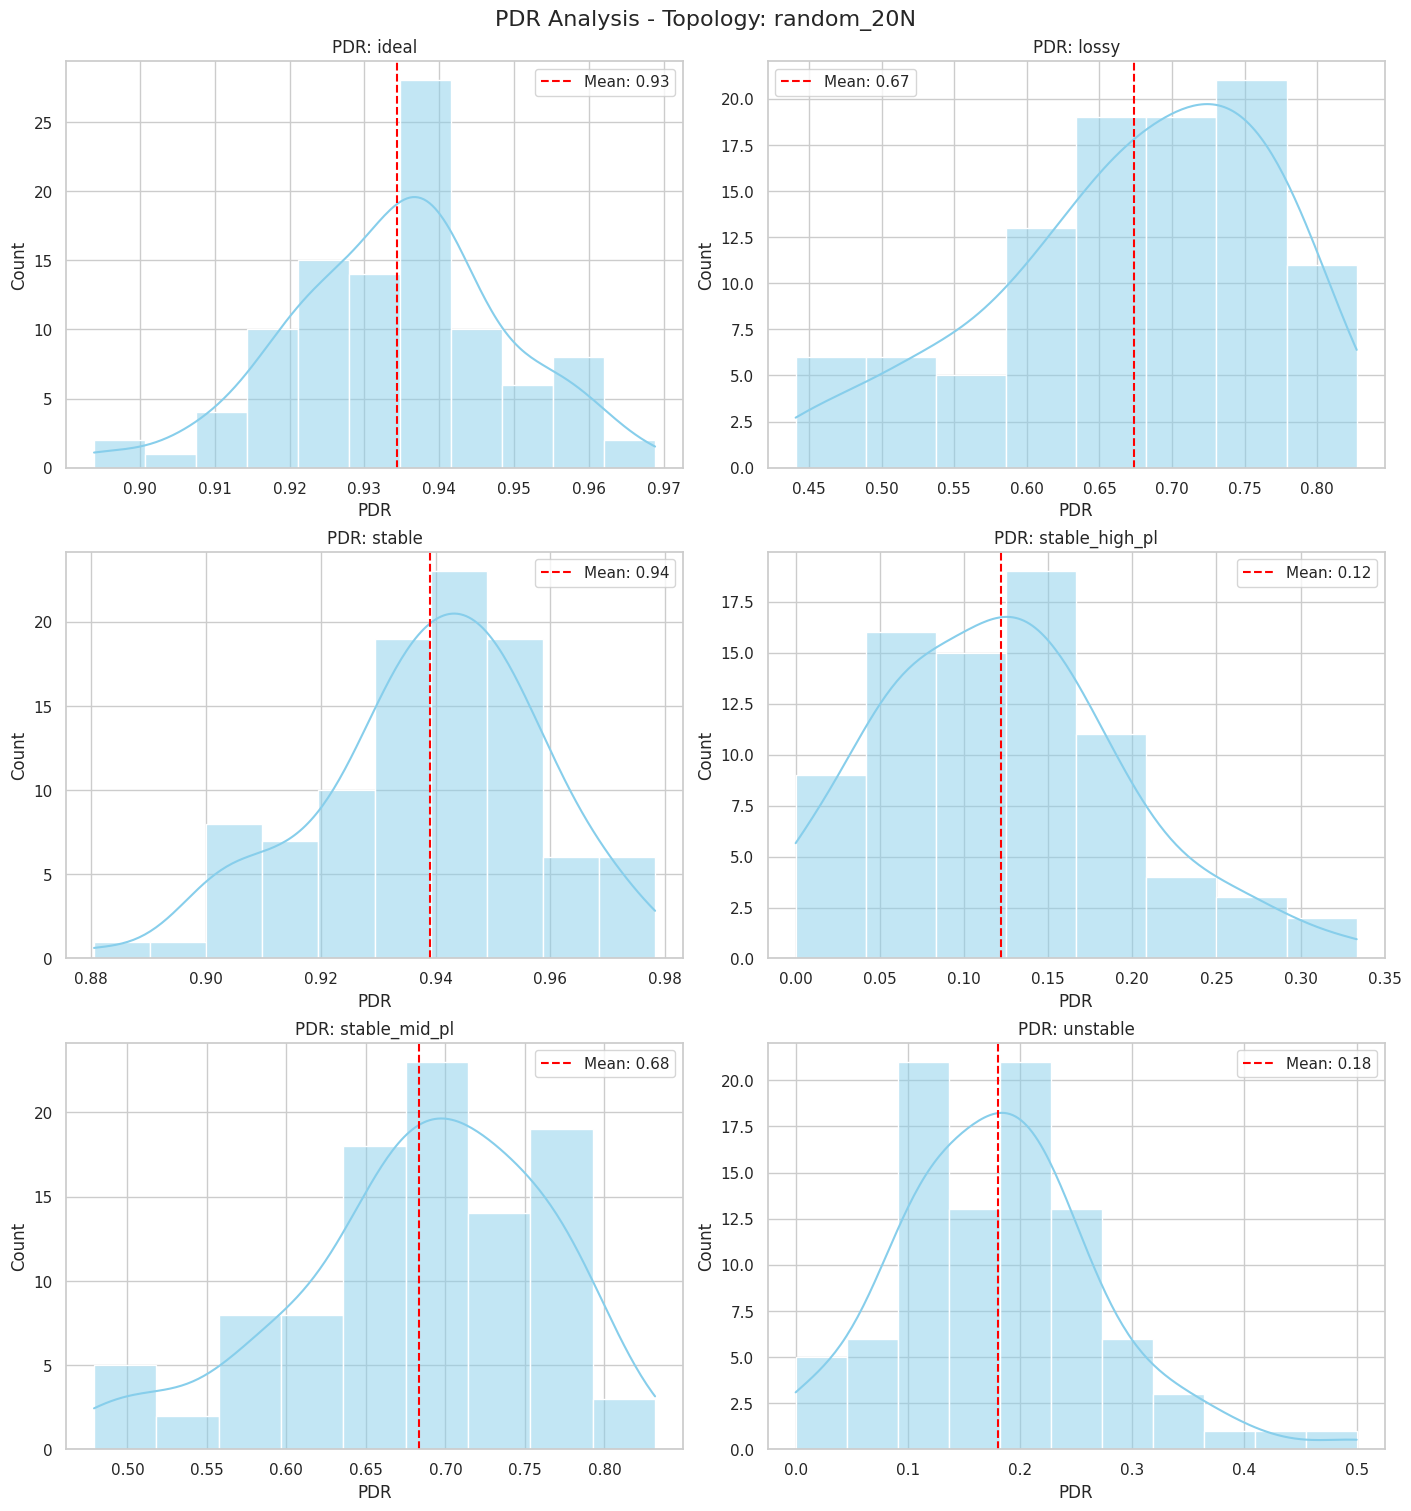

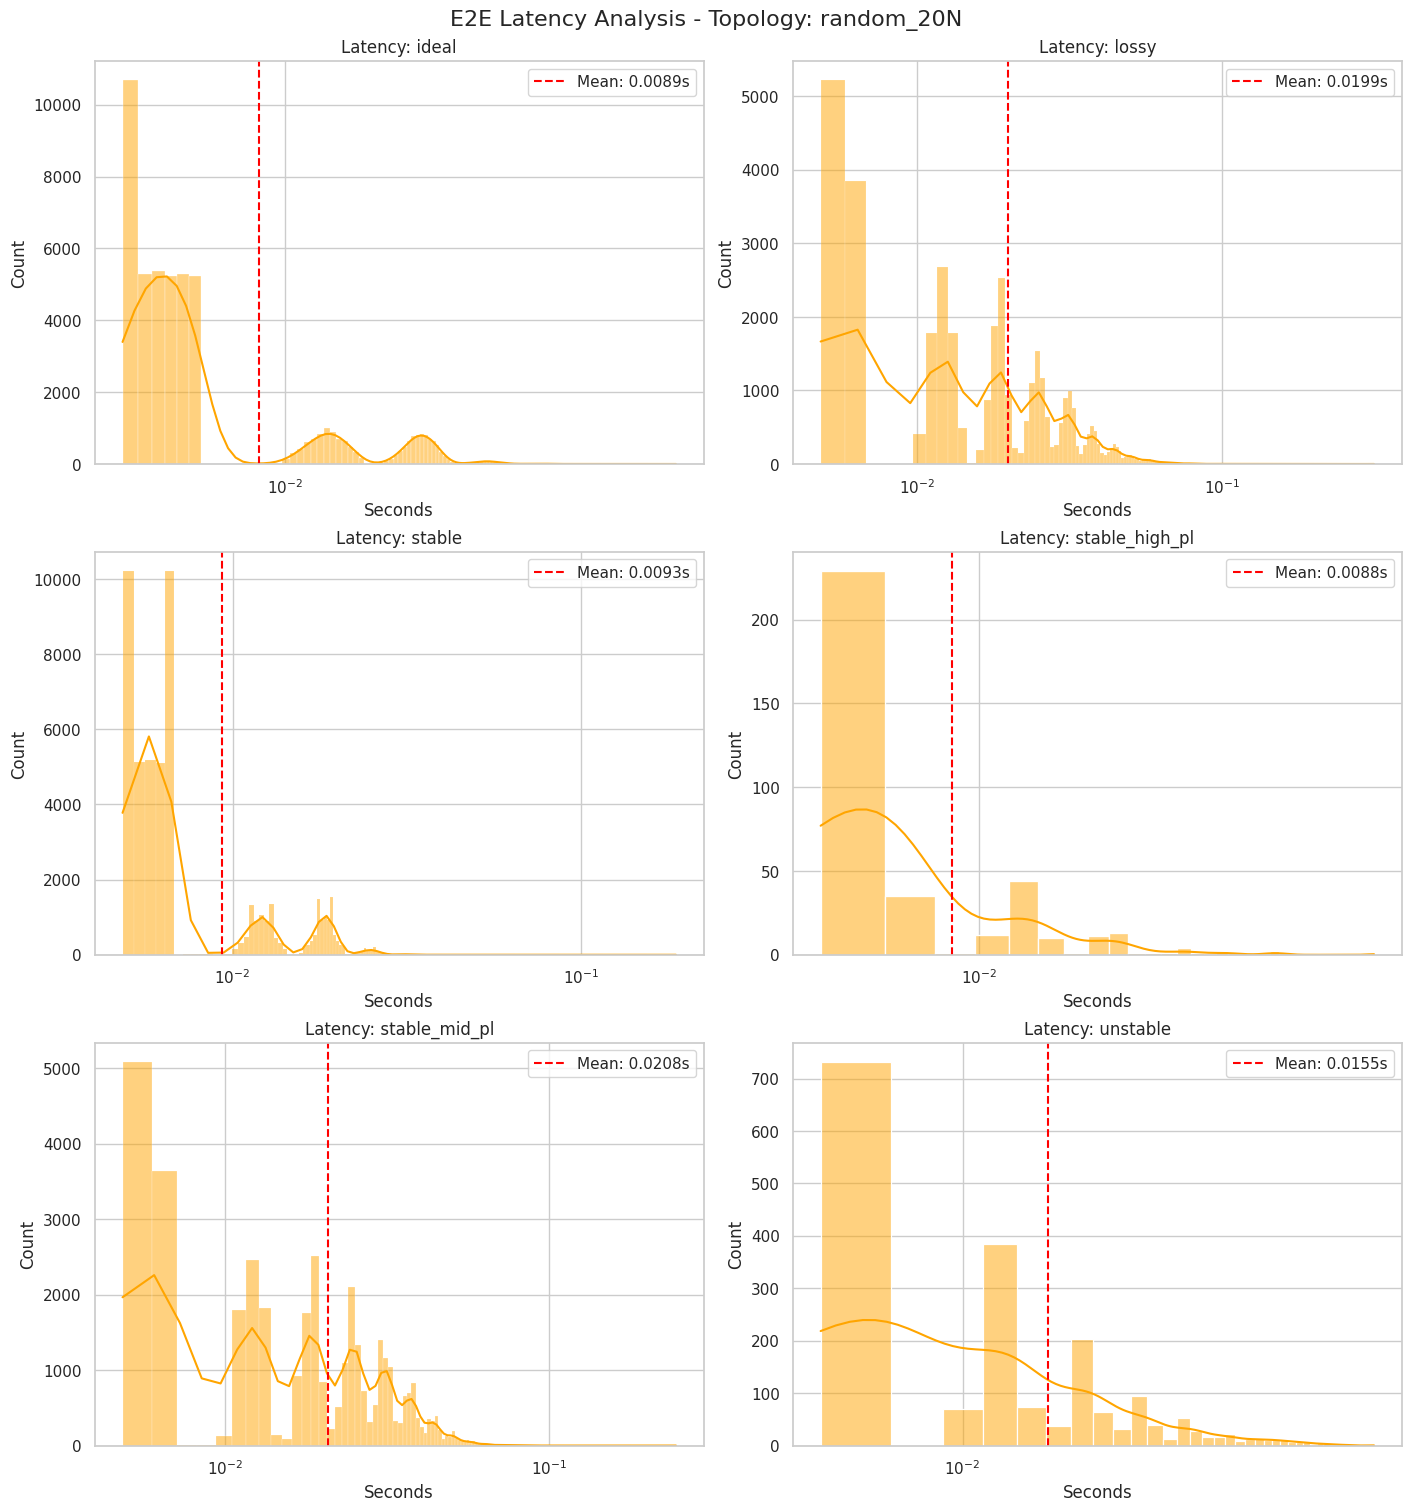

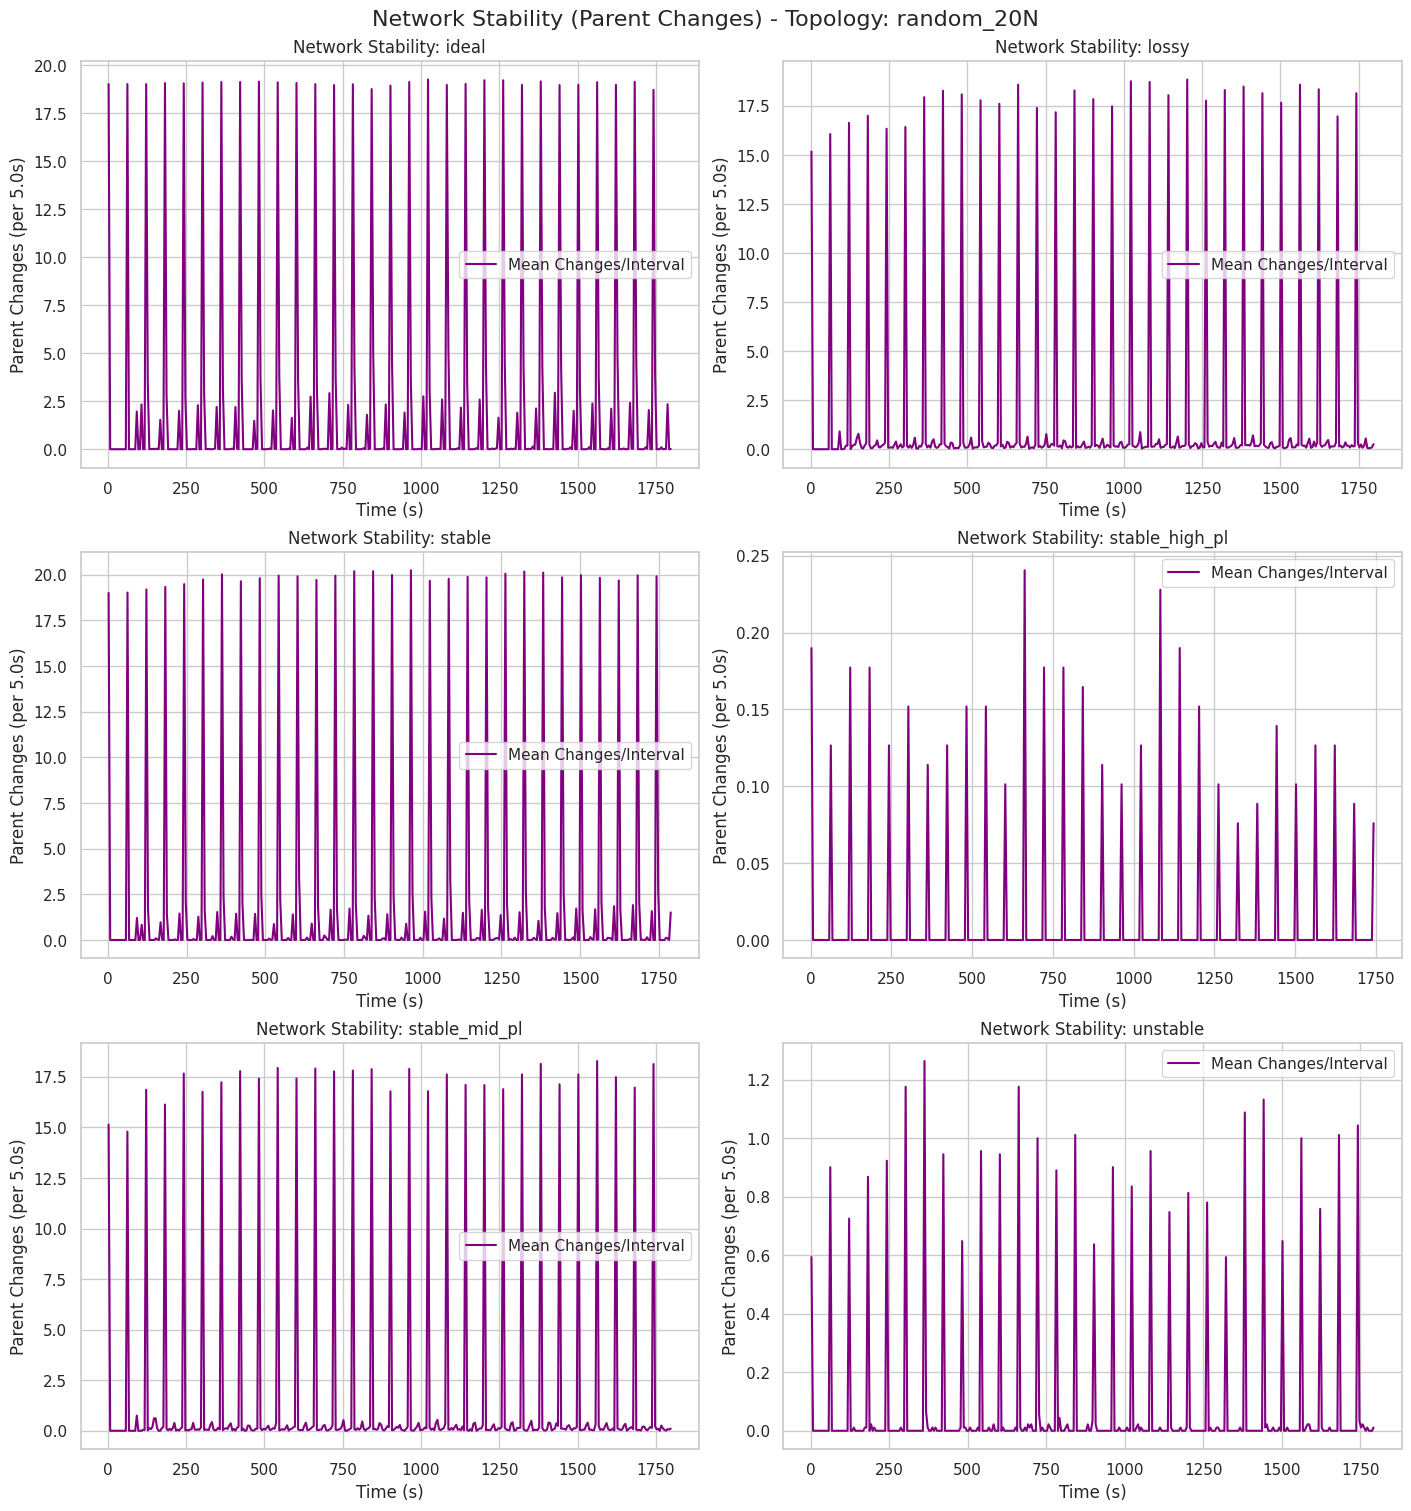

Analysis Complete.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import math
import warnings

# =============================================================================
# --- Configuration ---
# =============================================================================

# Path configuration
PATH_TO_RESULTS_PARENT_FOLDER = Path("/home/damole/Documents/develop/SPE-project/results/batch_20251120_11-00-03")
TOPOLOGY_FOLDER_TO_ANALYZE = "random_20N"

# Log File Names
PDR_LOG_FILE = "log_PDR.csv"
LATENCY_LOG_FILE = "log_e2eLat.csv"
PARENT_CHG_LOG_FILE = "log_ParChg.csv"

# Time window size (in seconds) to aggregate parent changes
TIME_BIN_SIZE_S = 5.0 

# Plot style
sns.set_theme(style="whitegrid", palette="muted")
warnings.filterwarnings('ignore', category=UserWarning, module='seaborn')
warnings.filterwarnings('ignore', category=FutureWarning, module='pandas')

# =============================================================================
# --- Helper Functions ---
# =============================================================================

def process_pdr_file(file_path):
    """Reads PDR file and returns the mean PDR of that run."""
    try:
        df = pd.read_csv(file_path, skipinitialspace=True)
        if df.empty or 'delivered' not in df.columns:
            return None
        return df['delivered'].mean()
    except Exception:
        return None

def process_latency_file(file_path):
    """Reads Latency file and returns a list of latency values."""
    try:
        df = pd.read_csv(file_path, skipinitialspace=True)
        if df.empty or 'latency' not in df.columns:
            return []
        return df['latency'].tolist()
    except Exception:
        return []

def process_parent_change_files(file_paths, bin_size=1.0):
    """
    Aggregates parent change events over time across multiple runs.
    
    Returns:
        bin_centers (np.array): The time axis.
        mean_counts (np.array): Average parent changes per bin.
    """
    if not file_paths:
        return None, None

    all_histograms = []
    max_time = 0
    
    # First pass: Determine max simulation time to define bins common to all runs
    for fp in file_paths:
        try:
            df = pd.read_csv(fp, skipinitialspace=True)
            if not df.empty and 'timestamp' in df.columns:
                local_max = df['timestamp'].max()
                if local_max > max_time:
                    max_time = local_max
        except Exception:
            continue
    
    if max_time == 0:
        return None, None

    # Define bins
    bins = np.arange(0, math.ceil(max_time) + bin_size, bin_size)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    # Second pass: Histogram the data for each run
    valid_runs = 0
    for fp in file_paths:
        try:
            df = pd.read_csv(fp, skipinitialspace=True)
            if df.empty or 'timestamp' not in df.columns:
                continue
            
            # Count events in each time bin
            counts, _ = np.histogram(df['timestamp'], bins=bins)
            all_histograms.append(counts)
            valid_runs += 1
        except Exception:
            continue

    if valid_runs == 0:
        return None, None

    # Stack arrays: shape (num_runs, num_bins)
    data_matrix = np.vstack(all_histograms)
    
    # Calculate Statistics (ONLY MEAN, NO CI)
    mean_counts = np.mean(data_matrix, axis=0)
        
    return bin_centers, mean_counts

# =============================================================================
# --- Main Analysis ---
# =============================================================================

analysis_base_path = PATH_TO_RESULTS_PARENT_FOLDER / TOPOLOGY_FOLDER_TO_ANALYZE

if not analysis_base_path.exists():
    print(f"CRITICAL ERROR: Path does not exist: {analysis_base_path}")
    sys.exit(1)

print(f"Analyizing Topology: {TOPOLOGY_FOLDER_TO_ANALYZE}")

# 1. Discover Configurations (subfolders)
configs = sorted([d for d in analysis_base_path.iterdir() if d.is_dir()])
if not configs:
    print("No configuration folders found.")
    sys.exit(0)

# Data storage structure
results = {} 

# --- DATA COLLECTION PHASE ---
print("Collecting data from files...")
for config_dir in configs:
    config_name = config_dir.name
    print(f"  > Processing config: {config_name}")
    
    seed_dirs = sorted([d for d in config_dir.iterdir() if d.is_dir()])
    
    pdr_data = []
    lat_data = []
    par_chg_files = []
    
    for seed in seed_dirs:
        # PDR
        p = process_pdr_file(seed / PDR_LOG_FILE)
        if p is not None: pdr_data.append(p)
        
        # Latency
        l = process_latency_file(seed / LATENCY_LOG_FILE)
        if l: lat_data.extend(l)
        
        # Parent Changes (Store path only, process later)
        pc_file = seed / PARENT_CHG_LOG_FILE
        if pc_file.exists():
            par_chg_files.append(pc_file)
            
    results[config_name] = {
        'pdr': np.array(pdr_data),
        'latency': np.array(lat_data),
        'par_chg_files': par_chg_files
    }

# --- PLOTTING SETUP ---
num_configs = len(configs)
cols = 2 
rows = math.ceil(num_configs / cols)

# Create a grid of subplots
fig_pdr, axes_pdr = plt.subplots(rows, cols, figsize=(14, 5 * rows), constrained_layout=True)
fig_lat, axes_lat = plt.subplots(rows, cols, figsize=(14, 5 * rows), constrained_layout=True)
fig_pc, axes_pc = plt.subplots(rows, cols, figsize=(14, 5 * rows), constrained_layout=True)

# Flatten axes for easy iteration if > 1
axes_pdr = np.array(axes_pdr).flatten() if num_configs > 1 else [axes_pdr]
axes_lat = np.array(axes_lat).flatten() if num_configs > 1 else [axes_lat]
axes_pc = np.array(axes_pc).flatten() if num_configs > 1 else [axes_pc]

# --- PLOTTING PHASE ---
for idx, config_dir in enumerate(configs):
    config_name = config_dir.name
    data = results[config_name]
    
    # 1. PDR Plot
    ax = axes_pdr[idx]
    if len(data['pdr']) > 0:
        mean_val = data['pdr'].mean()
        sns.histplot(data['pdr'], kde=True, ax=ax, color='skyblue')
        ax.axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.2f}')
        ax.set_title(f"PDR: {config_name}")
        ax.set_xlabel("PDR")
        ax.legend()
    else:
        ax.text(0.5, 0.5, "No Data", ha='center', va='center')

    # 2. Latency Plot
    ax = axes_lat[idx]
    if len(data['latency']) > 0:
        mean_val = data['latency'].mean()
        sns.histplot(data['latency'], kde=True, ax=ax, color='orange')
        ax.axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.4f}s')
        ax.set_title(f"Latency: {config_name}")
        ax.set_xlabel("Seconds")
        if data['latency'].max() > 10 * (data['latency'].min() + 1e-9):
             ax.set_xscale('log')
        ax.legend()
    else:
        ax.text(0.5, 0.5, "No Data", ha='center', va='center')

    # 3. Parent Change Stability Plot
    ax = axes_pc[idx]
    # UPDATED: Returns only 2 values now
    t_axis, mean_counts = process_parent_change_files(data['par_chg_files'], bin_size=TIME_BIN_SIZE_S)
    
    if t_axis is not None:
        # Plot Mean Only
        ax.plot(t_axis, mean_counts, color='purple', label='Mean Changes/Interval')
        # NO FILL_BETWEEN HERE
        
        ax.set_title(f"Network Stability: {config_name}")
        ax.set_xlabel("Time (s)")
        ax.set_ylabel(f"Parent Changes (per {TIME_BIN_SIZE_S}s)")
        ax.legend()
    else:
        ax.text(0.5, 0.5, "No ParChg Data", ha='center', va='center')

# Hide unused subplots
for i in range(idx + 1, len(axes_pdr)):
    axes_pdr[i].axis('off')
    axes_lat[i].axis('off')
    axes_pc[i].axis('off')

# Add Global Titles
fig_pdr.suptitle(f"PDR Analysis - Topology: {TOPOLOGY_FOLDER_TO_ANALYZE}", fontsize=16)
fig_lat.suptitle(f"E2E Latency Analysis - Topology: {TOPOLOGY_FOLDER_TO_ANALYZE}", fontsize=16)
fig_pc.suptitle(f"Network Stability (Parent Changes) - Topology: {TOPOLOGY_FOLDER_TO_ANALYZE}", fontsize=16)

# Save or Show
print("\nPlots generated. Showing...")
plt.show()

print("Analysis Complete.")

Analyizing Topology: random_20N
  > Processing config: ideal
  > Processing config: lossy
  > Processing config: stable
  > Processing config: stable_high_pl
  > Processing config: stable_mid_pl
  > Processing config: unstable

Plots generated. Showing...


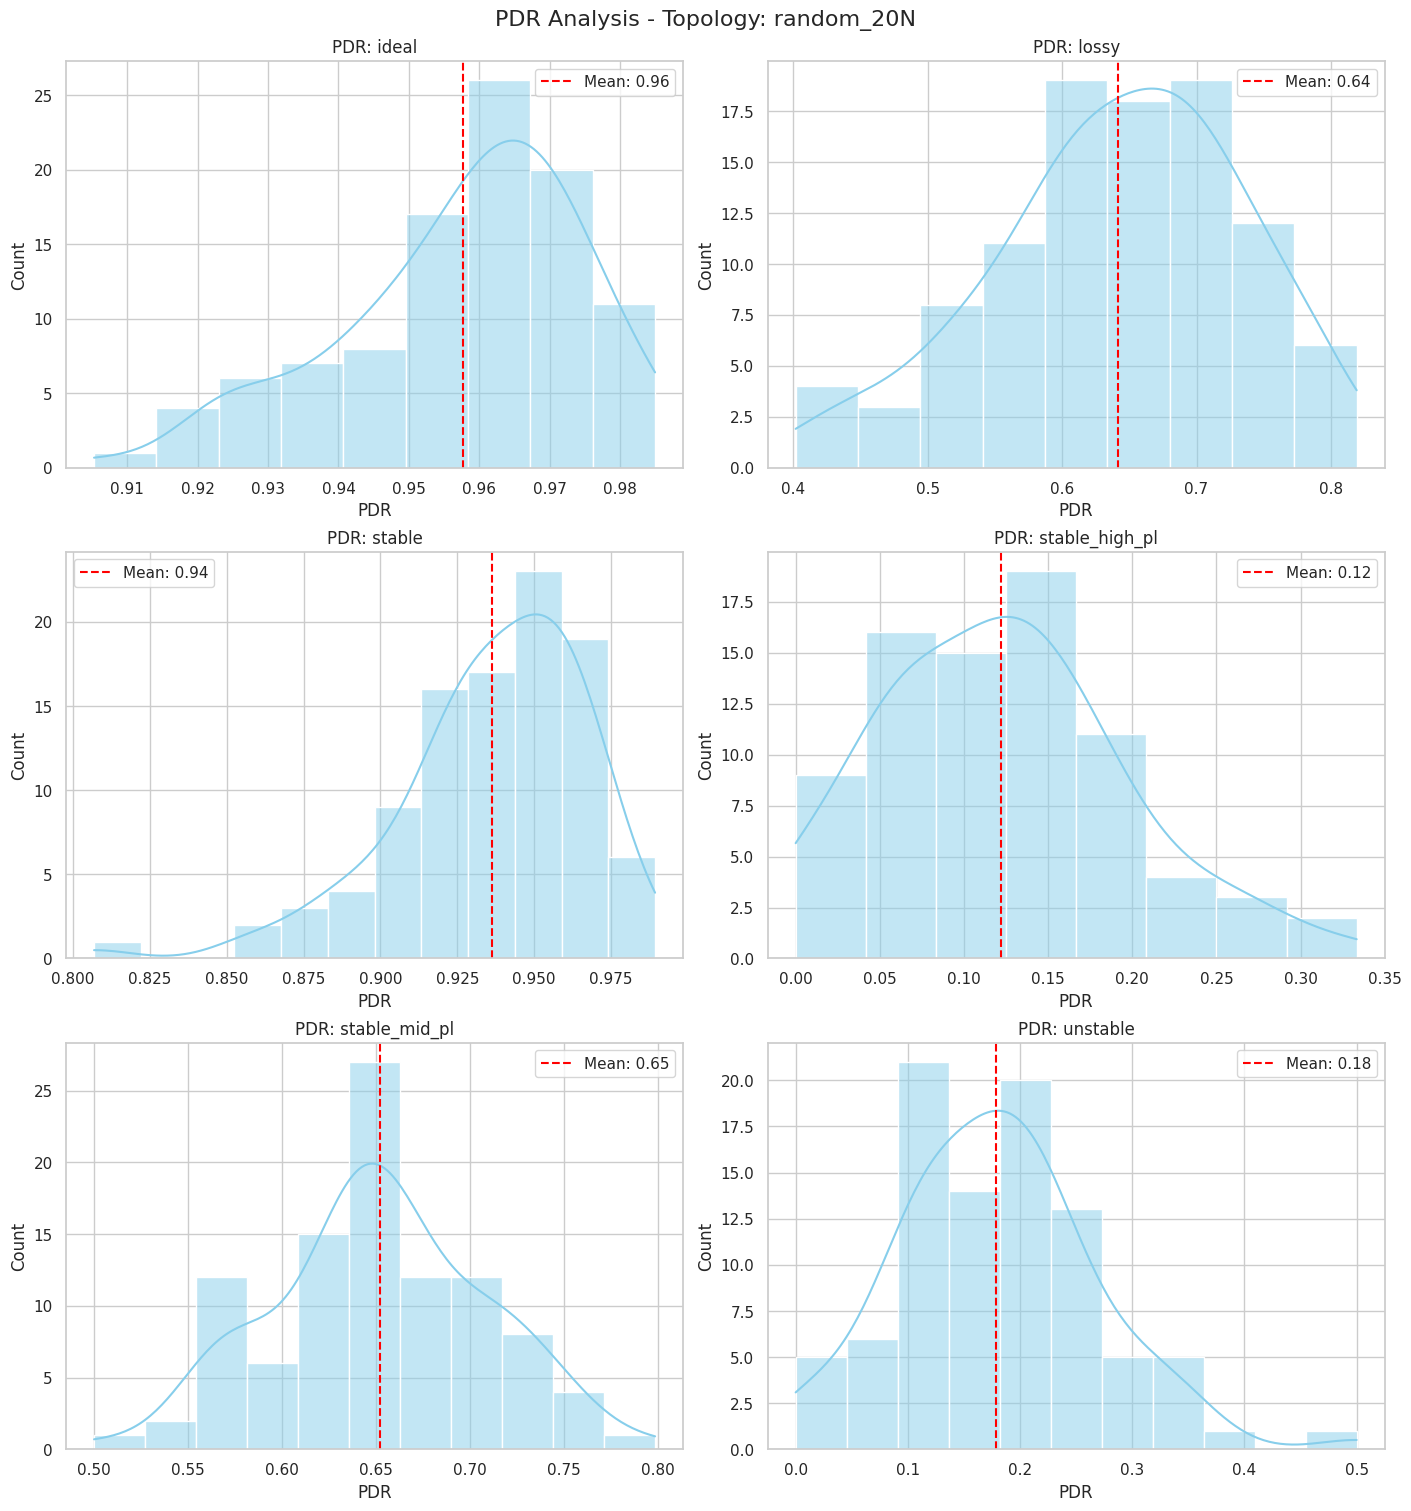

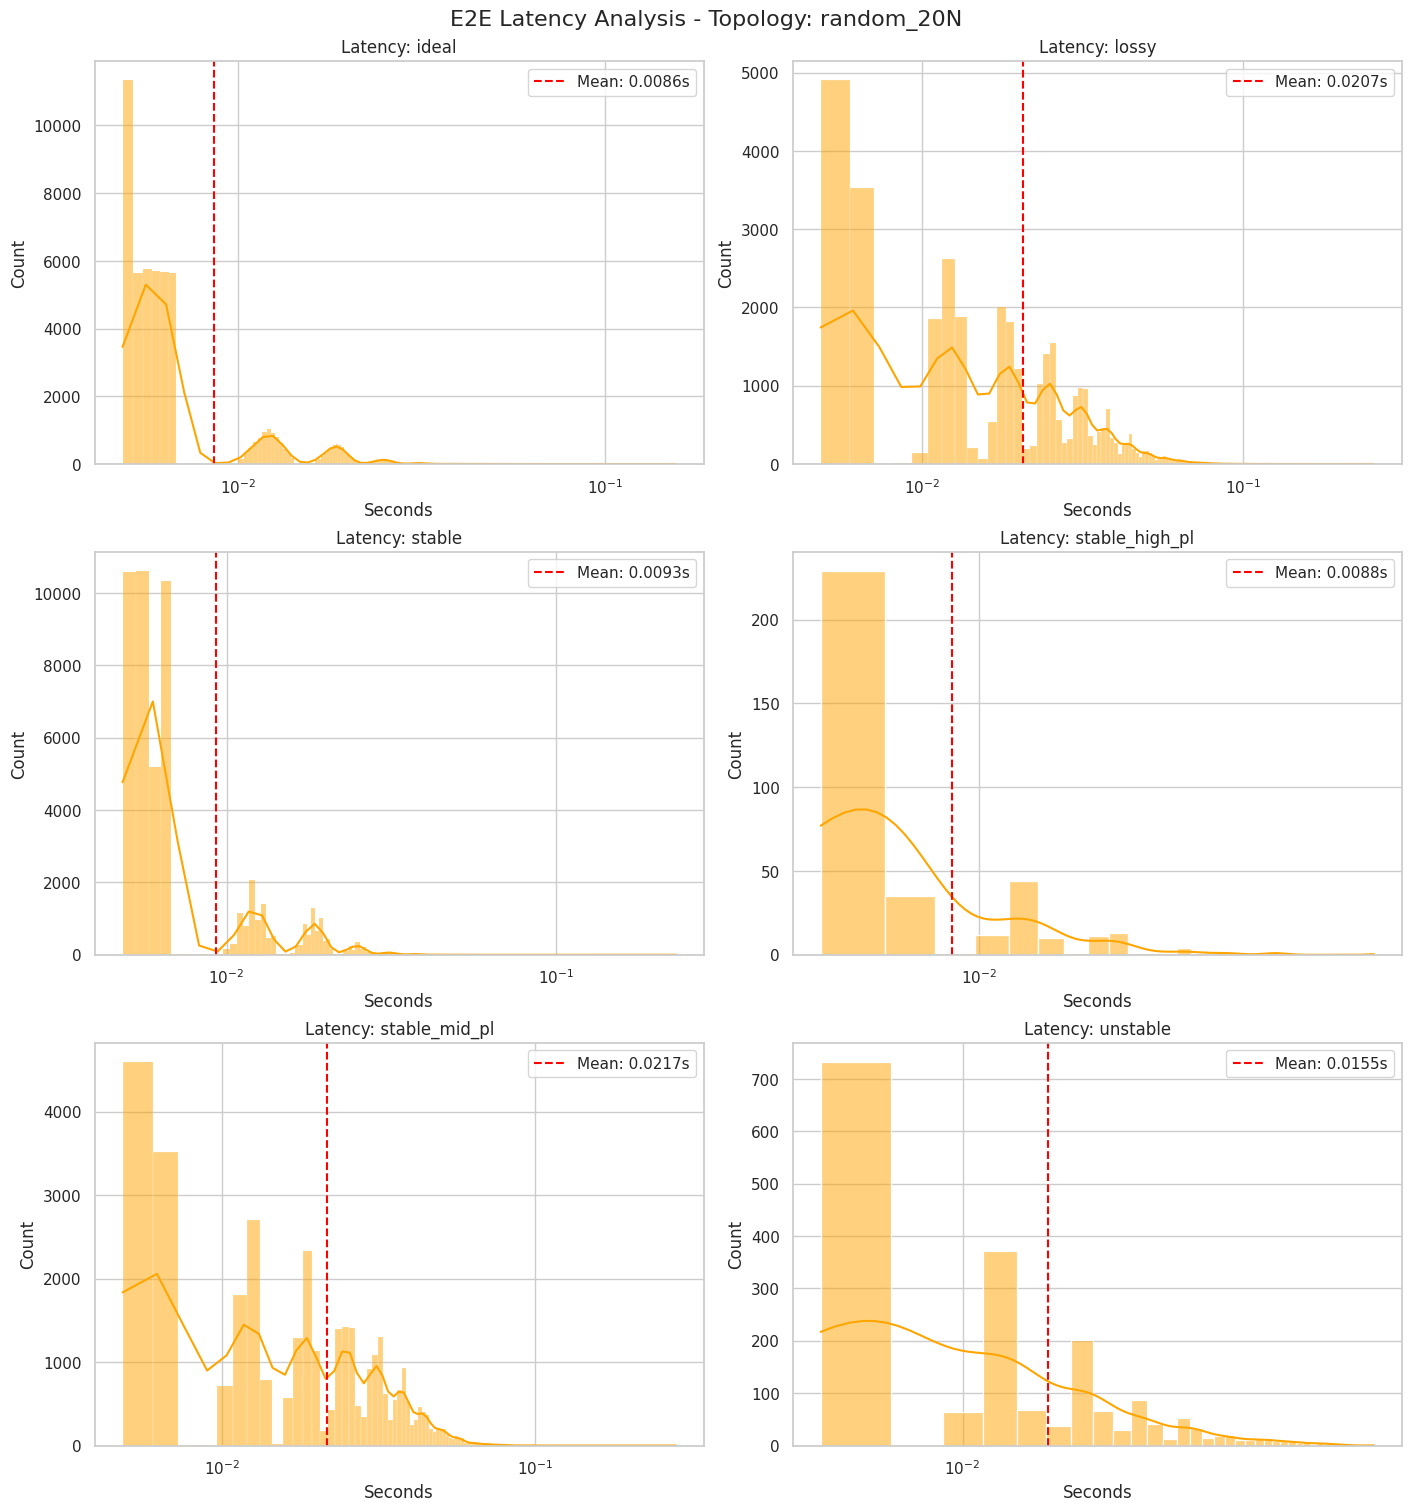

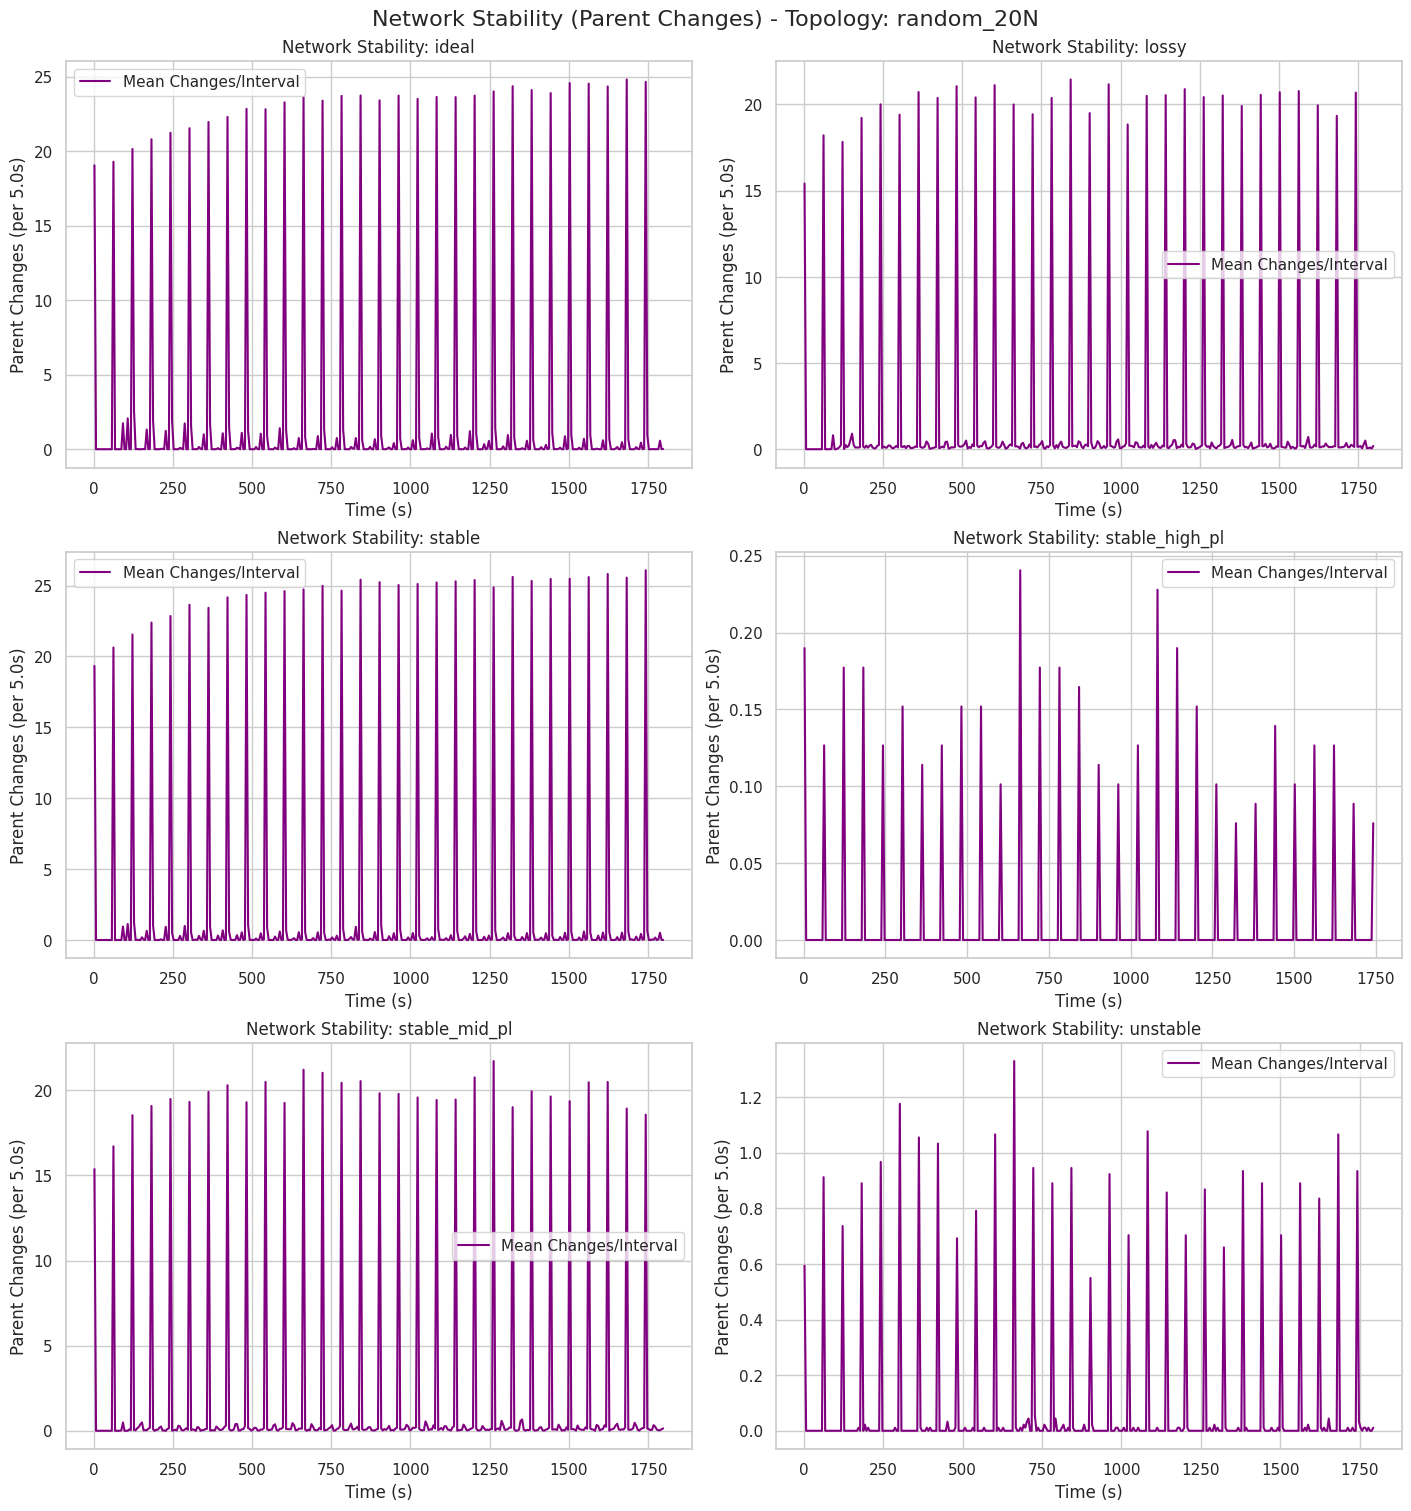

Analysis Complete.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import math
import warnings

# =============================================================================
# --- Configuration ---
# =============================================================================

# Path configuration
PATH_TO_RESULTS_PARENT_FOLDER = Path("/home/damole/Documents/develop/SPE-project/results/batch_20251121_23-09-00")
TOPOLOGY_FOLDER_TO_ANALYZE = "random_20N"

# Log File Names
PDR_LOG_FILE = "log_PDR.csv"
LATENCY_LOG_FILE = "log_e2eLat.csv"
PARENT_CHG_LOG_FILE = "log_ParChg.csv"

# Time window size (in seconds) to aggregate parent changes
TIME_BIN_SIZE_S = 5.0 

# Plot style
sns.set_theme(style="whitegrid", palette="muted")
warnings.filterwarnings('ignore', category=UserWarning, module='seaborn')
warnings.filterwarnings('ignore', category=FutureWarning, module='pandas')

# =============================================================================
# --- Helper Functions ---
# =============================================================================

def process_pdr_file(file_path):
    """Reads PDR file and returns the mean PDR of that run."""
    try:
        df = pd.read_csv(file_path, skipinitialspace=True)
        if df.empty or 'delivered' not in df.columns:
            return None
        return df['delivered'].mean()
    except Exception:
        return None

def process_latency_file(file_path):
    """Reads Latency file and returns a list of latency values."""
    try:
        df = pd.read_csv(file_path, skipinitialspace=True)
        if df.empty or 'latency' not in df.columns:
            return []
        return df['latency'].tolist()
    except Exception:
        return []

def process_parent_change_files(file_paths, bin_size=1.0):
    """
    Aggregates parent change events over time across multiple runs.
    
    Returns:
        bin_centers (np.array): The time axis.
        mean_counts (np.array): Average parent changes per bin.
    """
    if not file_paths:
        return None, None

    all_histograms = []
    max_time = 0
    
    # First pass: Determine max simulation time to define bins common to all runs
    for fp in file_paths:
        try:
            df = pd.read_csv(fp, skipinitialspace=True)
            if not df.empty and 'timestamp' in df.columns:
                local_max = df['timestamp'].max()
                if local_max > max_time:
                    max_time = local_max
        except Exception:
            continue
    
    if max_time == 0:
        return None, None

    # Define bins
    bins = np.arange(0, math.ceil(max_time) + bin_size, bin_size)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    # Second pass: Histogram the data for each run
    valid_runs = 0
    for fp in file_paths:
        try:
            df = pd.read_csv(fp, skipinitialspace=True)
            if df.empty or 'timestamp' not in df.columns:
                continue
            
            # Count events in each time bin
            counts, _ = np.histogram(df['timestamp'], bins=bins)
            all_histograms.append(counts)
            valid_runs += 1
        except Exception:
            continue

    if valid_runs == 0:
        return None, None

    # Stack arrays: shape (num_runs, num_bins)
    data_matrix = np.vstack(all_histograms)
    
    # Calculate Statistics (ONLY MEAN, NO CI)
    mean_counts = np.mean(data_matrix, axis=0)
        
    return bin_centers, mean_counts

# =============================================================================
# --- Main Analysis ---
# =============================================================================

analysis_base_path = PATH_TO_RESULTS_PARENT_FOLDER / TOPOLOGY_FOLDER_TO_ANALYZE

if not analysis_base_path.exists():
    print(f"CRITICAL ERROR: Path does not exist: {analysis_base_path}")
    sys.exit(1)

print(f"Analyizing Topology: {TOPOLOGY_FOLDER_TO_ANALYZE}")

# 1. Discover Configurations (subfolders)
configs = sorted([d for d in analysis_base_path.iterdir() if d.is_dir()])
if not configs:
    print("No configuration folders found.")
    sys.exit(0)

# Data storage structure
results = {} 

# --- DATA COLLECTION PHASE ---
print("Collecting data from files...")
for config_dir in configs:
    config_name = config_dir.name
    print(f"  > Processing config: {config_name}")
    
    seed_dirs = sorted([d for d in config_dir.iterdir() if d.is_dir()])
    
    pdr_data = []
    lat_data = []
    par_chg_files = []
    
    for seed in seed_dirs:
        # PDR
        p = process_pdr_file(seed / PDR_LOG_FILE)
        if p is not None: pdr_data.append(p)
        
        # Latency
        l = process_latency_file(seed / LATENCY_LOG_FILE)
        if l: lat_data.extend(l)
        
        # Parent Changes (Store path only, process later)
        pc_file = seed / PARENT_CHG_LOG_FILE
        if pc_file.exists():
            par_chg_files.append(pc_file)
            
    results[config_name] = {
        'pdr': np.array(pdr_data),
        'latency': np.array(lat_data),
        'par_chg_files': par_chg_files
    }

# --- PLOTTING SETUP ---
num_configs = len(configs)
cols = 2 
rows = math.ceil(num_configs / cols)

# Create a grid of subplots
fig_pdr, axes_pdr = plt.subplots(rows, cols, figsize=(14, 5 * rows), constrained_layout=True)
fig_lat, axes_lat = plt.subplots(rows, cols, figsize=(14, 5 * rows), constrained_layout=True)
fig_pc, axes_pc = plt.subplots(rows, cols, figsize=(14, 5 * rows), constrained_layout=True)

# Flatten axes for easy iteration if > 1
axes_pdr = np.array(axes_pdr).flatten() if num_configs > 1 else [axes_pdr]
axes_lat = np.array(axes_lat).flatten() if num_configs > 1 else [axes_lat]
axes_pc = np.array(axes_pc).flatten() if num_configs > 1 else [axes_pc]

# --- PLOTTING PHASE ---
for idx, config_dir in enumerate(configs):
    config_name = config_dir.name
    data = results[config_name]
    
    # 1. PDR Plot
    ax = axes_pdr[idx]
    if len(data['pdr']) > 0:
        mean_val = data['pdr'].mean()
        sns.histplot(data['pdr'], kde=True, ax=ax, color='skyblue')
        ax.axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.2f}')
        ax.set_title(f"PDR: {config_name}")
        ax.set_xlabel("PDR")
        ax.legend()
    else:
        ax.text(0.5, 0.5, "No Data", ha='center', va='center')

    # 2. Latency Plot
    ax = axes_lat[idx]
    if len(data['latency']) > 0:
        mean_val = data['latency'].mean()
        sns.histplot(data['latency'], kde=True, ax=ax, color='orange')
        ax.axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.4f}s')
        ax.set_title(f"Latency: {config_name}")
        ax.set_xlabel("Seconds")
        if data['latency'].max() > 10 * (data['latency'].min() + 1e-9):
             ax.set_xscale('log')
        ax.legend()
    else:
        ax.text(0.5, 0.5, "No Data", ha='center', va='center')

    # 3. Parent Change Stability Plot
    ax = axes_pc[idx]
    # UPDATED: Returns only 2 values now
    t_axis, mean_counts = process_parent_change_files(data['par_chg_files'], bin_size=TIME_BIN_SIZE_S)
    
    if t_axis is not None:
        # Plot Mean Only
        ax.plot(t_axis, mean_counts, color='purple', label='Mean Changes/Interval')
        # NO FILL_BETWEEN HERE
        
        ax.set_title(f"Network Stability: {config_name}")
        ax.set_xlabel("Time (s)")
        ax.set_ylabel(f"Parent Changes (per {TIME_BIN_SIZE_S}s)")
        ax.legend()
    else:
        ax.text(0.5, 0.5, "No ParChg Data", ha='center', va='center')

# Hide unused subplots
for i in range(idx + 1, len(axes_pdr)):
    axes_pdr[i].axis('off')
    axes_lat[i].axis('off')
    axes_pc[i].axis('off')

# Add Global Titles
fig_pdr.suptitle(f"PDR Analysis - Topology: {TOPOLOGY_FOLDER_TO_ANALYZE}", fontsize=16)
fig_lat.suptitle(f"E2E Latency Analysis - Topology: {TOPOLOGY_FOLDER_TO_ANALYZE}", fontsize=16)
fig_pc.suptitle(f"Network Stability (Parent Changes) - Topology: {TOPOLOGY_FOLDER_TO_ANALYZE}", fontsize=16)

# Save or Show
print("\nPlots generated. Showing...")
plt.show()

print("Analysis Complete.")